In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import geopandas
from geodatasets import get_path

### Section 3.2

Correlation between census-tract derived and OMEinfo derived population densities using data from the study: "Soil Bacterial Diversity Is Associated with Human Population Density in Urban Greenspaces"

Diversity data and locations were provided by the authors of the study, and were used to determine the correlation between the two methods following annotation with OMEinfo v1.0.0 and OMEinfo data packet v2. A small number of samples were excluded from analysis where locations provided resulted in water tiles within the data packet. This can happen when locations are given at a low resolution, as for example at 2 decimal places, a location is only accurate to 1km. Biological conclusions from the paper were confirmed to still be present upon exclusion of these samples prior to subsequent investigations.

In [3]:
soil_data = pd.read_csv("soil_annotated_metadata.csv")
soil_data = soil_data.loc[soil_data["Population Density"] != 0]

To confirm the biological signal still exists upon exclusion of these samples, will replicate the result seen in Table 1 (Shannon rho = 0.236, p-val 0.009, PD rho = 0.270, p-val 0.003)

In [14]:
original_shannon_rho, original_shannon_p_value = spearmanr(soil_data["Population.Density"], soil_data["Shannon"])
original_pd_rho, original_pd_p_value = spearmanr(soil_data["Population.Density"], soil_data["PD_whole_tree"])
print("Spearman's Rank Correlation Coefficient (Original Pop Dens + Shannon Diversity):", original_shannon_rho)
print("p-value:", original_shannon_p_value)

print("Spearman's Rank Correlation Coefficient (Original Pop Dens + Phylogenetic Diversity):", original_pd_rho)
print("p-value:", original_pd_p_value)

Spearman's Rank Correlation Coefficient (Original Pop Dens + Shannon Diversity): 0.22479821446106724
p-value: 0.006192824004836474
Spearman's Rank Correlation Coefficient (Original Pop Dens + Phylogenetic Diversity): 0.2585350436345963
p-value: 0.00156827424504645


In [ ]:
plt.xlabel('Census Derived Population Density')
plt.ylabel('Shannon Diversity')
plt.title('Association between Population Density and Shannon Diversity')
plt.scatter(x = soil_data["Population Density"], y = soil_data["Shannon"])
plt.show()

Can see that there is still the same biological correlation in the data, so will go on to investigate OMEinfo determined population densities. However, first, will check the correlation between the two population densities. 

### Figure S1

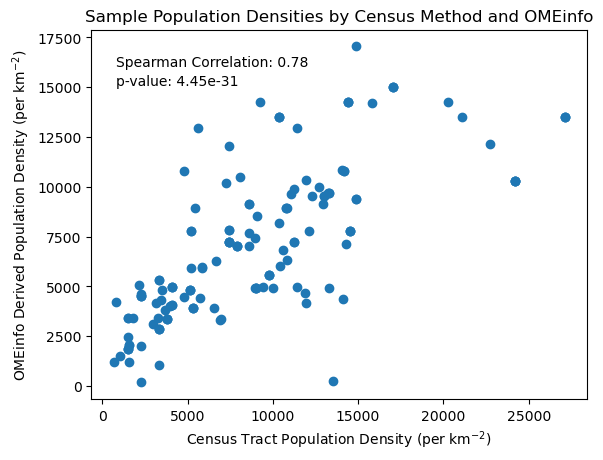

In [60]:
pop_dens_rho, pop_dens_p_value = spearmanr(soil_data["Population.Density"], soil_data["Population Density"])

plt.xlabel('Census Tract Population Density (per $\mathrm{km^{-2}}$)')
plt.ylabel('OMEinfo Derived Population Density (per $\mathrm{km^{-2}}$)')
plt.title('Sample Population Densities by Census Method and OMEinfo')
plt.scatter(x = soil_data.loc[soil_data["Population Density"] != 0, "Population.Density"], y = soil_data.loc[soil_data["Population Density"] != 0, "Population Density"], label = soil_data.loc[soil_data["Population Density"] != 0, "sample"])
plt.text(0.05, 0.9, f'Spearman Correlation: {pop_dens_rho:.2f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.85, f'p-value: {pop_dens_p_value:.2e}', transform=plt.gca().transAxes)
plt.savefig("pop_dens_corr_figure_s1.png", dpi = 600)
plt.show()

Now, to look at whether the correlation seen in table 1 of the publication are still present with OMEinfo derived metadata: 

### Figure S2

In [58]:
shannon_rho, shannon_p_value = spearmanr(soil_data.loc[soil_data["Population Density"] != 0, "Shannon"], soil_data.loc[soil_data["Population Density"] != 0, "Population Density"])
pd_rho, pd_p_value = spearmanr(soil_data.loc[soil_data["Population Density"] != 0, "PD_whole_tree"], soil_data.loc[soil_data["Population Density"] != 0, "Population Density"])
print("Spearman's Rank Correlation Coefficient (OMEinfo Population density + Shannon Diversity):", shannon_rho)
print("p-value:", shannon_p_value)

print("Spearman's Rank Correlation Coefficient (OMEinfo Population density + Phylogenetic Diversity):", pd_rho)
print("p-value:", pd_p_value)

Spearman's Rank Correlation Coefficient (OMEinfo Population density + Shannon Diversity): 0.21378585068952066
p-value: 0.009321850717265701
Spearman's Rank Correlation Coefficient (OMEinfo Population density + Phylogenetic Diversity): 0.24397769619090853
p-value: 0.002901773858072319


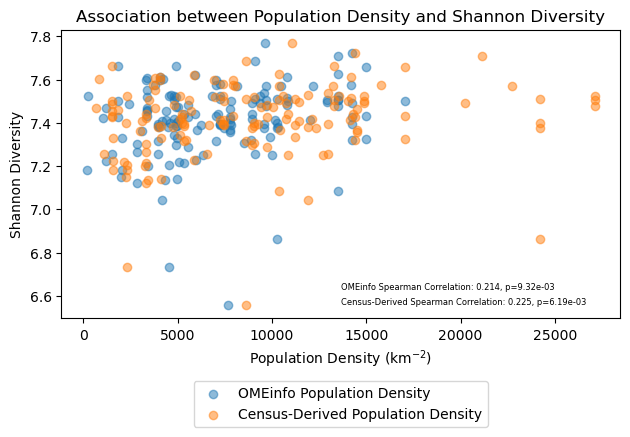

In [66]:
plt.scatter(x=soil_data["Population Density"], y=soil_data["Shannon"], label='OMEinfo Population Density', alpha=0.5)
plt.scatter(x=soil_data["Population.Density"], y=soil_data["Shannon"], label='Census-Derived Population Density', alpha=0.5)

plt.text(0.5, 0.1, f'OMEinfo Spearman Correlation: {shannon_rho:.3f}, p={shannon_p_value:.2e}', size = 6, transform=plt.gca().transAxes)
plt.text(0.5, 0.05, f'Census-Derived Spearman Correlation: {original_shannon_rho:.3f}, p={original_shannon_p_value:.2e}', size = 6, transform=plt.gca().transAxes)

plt.xlabel('Population Density ($\mathrm{km^{-2}}$)')
plt.ylabel('Shannon Diversity')
plt.title('Association between Population Density and Shannon Diversity')


plt.legend(bbox_to_anchor=(0.5, -0.4), loc='lower center')
plt.tight_layout()
plt.savefig("shannon_corr_figure_s2.png", dpi = 600)
plt.show()

### ENA Geographical Metadata Analysis

To create the current OMEinfo ENA dataset, metadata on all samples was retrieved [14/10/23] and processed through OMEinfo.

In [4]:
#read the ena metadata as downloaded and check for bad locations
ena_data = pd.read_csv("ena_search_results_141023.tsv.gz", sep = "\t", compression = "gzip")
bad_locations = ena_data.loc[ena_data[['latitude', 'longitude']].apply(lambda x: -90.00 <= x["latitude"] <= 90.00 and -180.00 <= x["longitude"] <= 180.00, axis=1) == False]

#import the omeinfo annotations
ena_annotations = pd.read_csv("ena_annotated.tsv.gz", sep = "\t", compression = "gzip")
ena_annotations_env = pd.read_csv("ena_annotated_environmental_fullmetadata.tsv.gz", sep = "\t", compression = "gzip")
ena_annotations_env_gdf = geopandas.GeoDataFrame(
    ena_annotations_env, geometry=geopandas.points_from_xy(ena_annotations_env.longitude, ena_annotations_env.latitude), crs="EPSG:4326"
)
#check for omeinfo errors (mostly points outside the geotiff bounds)
omeinfo_error_ena = ena_annotations.loc[ena_annotations.error.isna() == False]

#create the omeinfo datasets
omeinf_ena_dataset_v1 = ena_annotations.loc[ena_annotations.error.isna(), [col for col in ena_annotations.columns if col not in ["sample_description", "location", "environment_biome", "error"]]]
omeinf_ena_dataset_v1.to_csv("omeinfo_ena_dataset_v1.tsv.gz", index = False, sep = "\t",compression='gzip')

omeinfo_ena_env_dataset_v1 = ena_annotations_env[[col for col in ena_annotations.columns if col not in ["sample_description", "location", "environment_biome"]]]
omeinfo_ena_env_dataset_v1.to_csv("omeinfo_ena_env_dataset_v1.tsv.gz", index = False, sep = "\t",compression='gzip')

#find locations with 0.00N 0.00E locations (likely pseudo locs)
_0_locs = ena_annotations.loc[(ena_annotations.latitude == 0.0000) & (ena_annotations.longitude == 0.0000)]
_0_locs_biomes = _0_locs.environment_biome.unique()

/tmp/ipykernel_694416/273220036.py:6: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  ena_annotations = pd.read_csv("ena_annotated.tsv.gz", sep = "\t", compression = "gzip")
/tmp/ipykernel_694416/273220036.py:7: DtypeWarning: Columns (2,3,4,5,7,11,22,24,32,35,36,37,40,41,42,43,45,59,60,61,76,78,79,80,82,84,89,94) have mixed types. Specify dtype option on import or set low_memory=False.
  ena_annotations_env = pd.read_csv("ena_annotated_environmental_fullmetadata.tsv.gz", sep = "\t", compression = "gzip")


In [13]:
print(f"""A total of {len(bad_locations)} samples had invalid geographical coordinates, 
and {len(_0_locs)} samples were located at 0.00, 0.00""")

A total of 22626 samples had invalid geographical coordinates, 
and 3723 samples were located at 0.00, 0.00


We observe a lot of frequent locations reported for samples in the environmental dataset, here we will visualise the locations with more than 500 samples reported:

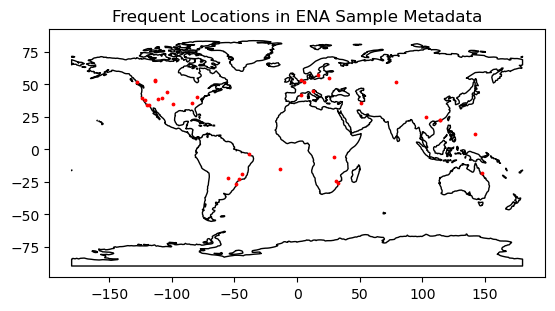

In [18]:
frequent_locations = ena_annotations_env.groupby(["latitude", "longitude"]).size().sort_values(ascending = False).rename("sample_count").reset_index()
frequent_locations = frequent_locations.loc[frequent_locations.sample_count > 500]

frequent_locations_gdf = geopandas.GeoDataFrame(
    frequent_locations, geometry=geopandas.points_from_xy(frequent_locations.longitude, frequent_locations.latitude), crs="EPSG:4326"
)

frequent_locations_full = ena_annotations_env_gdf.loc[ena_annotations_env_gdf.geometry.isin(ena_annotations_env_gdf.geometry)]

world = geopandas.read_file(get_path("naturalearth.land"))
ax = world.plot(color="white", edgecolor="black")

frequent_locations_gdf.plot(ax=ax, color="red", markersize=3)
plt.title("Frequent Locations in ENA Sample Metadata")
plt.show()

#### Figure 2
Sample metadata distribution in the ENA Env. dataset. A: The breakdown of samples according to the rurality index shows the majority of samples are from urban centres, very low-density locations or water. B: Breakdown of samples according to Köppen-Geiger Climate classification. Most samples are taken from “Temperate, no dry season, warm summer” climates.

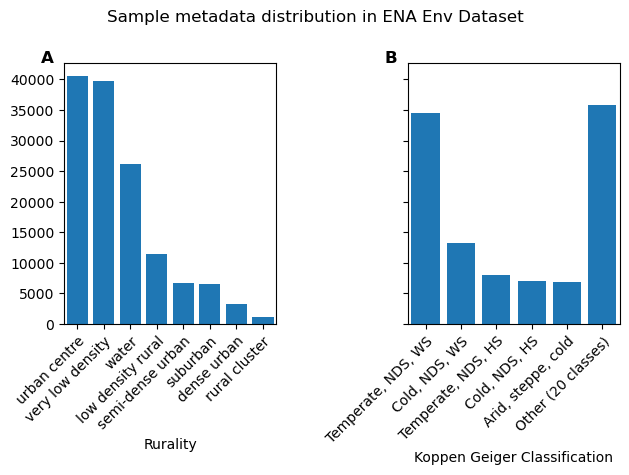

In [13]:
fig, axs = plt.subplots(1, 2, sharey = True)
fig.suptitle('Sample metadata distribution in ENA Env Dataset')

rurality_value_counts = ena_annotations_env["Rurality"].value_counts()
kg_value_counts = ena_annotations_env["Koppen Geiger"].value_counts()
kg_top_values = kg_value_counts.nlargest(5)
kg_other_count = kg_value_counts.nsmallest(len(kg_value_counts) - 5).sum()
kg_value_counts_top = pd.concat([kg_top_values,pd.Series({f'Other ({len(kg_value_counts.nsmallest(len(kg_value_counts) - 5))} classes)': kg_other_count})])
kg_value_counts_top.index.name = 'Koppen Geiger Classification'


rurality_value_counts.plot(kind = "bar", ax=axs[0])
kg_value_counts_top.plot(kind = "bar", ax=axs[1])


axs[0].bar(rurality_value_counts.index, rurality_value_counts.values)
axs[0].set_xticklabels(rurality_value_counts.index, rotation=45, ha='right', rotation_mode="anchor")
axs[0].text(-0.05, 1.05, 'A', transform=axs[0].transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

kg_labels = ["Temperate, NDS, WS", "Cold, NDS, WS", "Temperate, NDS, HS", "Cold, NDS, HS", "Arid, steppe, cold", "Other (20 classes)"]

axs[1].bar(kg_value_counts_top.index, kg_value_counts_top.values)
axs[1].set_xticklabels(kg_labels, rotation=45, ha='right', rotation_mode="anchor") #kg_value_counts_top.index
axs[0].text(-0.05, 1.05, 'B', transform=axs[1].transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

plt.tight_layout()  # Adjust subplot parameters to avoid overlapping
plt.savefig('metadata_distribution_plot.png', dpi = 600) 
plt.show()

In [22]:
ena_annotations_env.loc[ena_annotations_env["Koppen Geiger"].isin(["Temperate, no dry season, warm summer"])].shape[0] / ena_annotations_env.shape[0]

0.254115719798992

In [23]:
rurality_value_counts

Rurality
urban centre         40565
very low density     39716
water                26216
low density rural    11469
semi-dense urban      6666
suburban              6556
dense urban           3215
rural cluster         1114
Name: count, dtype: int64

Text(0.5, 1.0, 'Histogram of relative deprivation of sample locations in ENA')

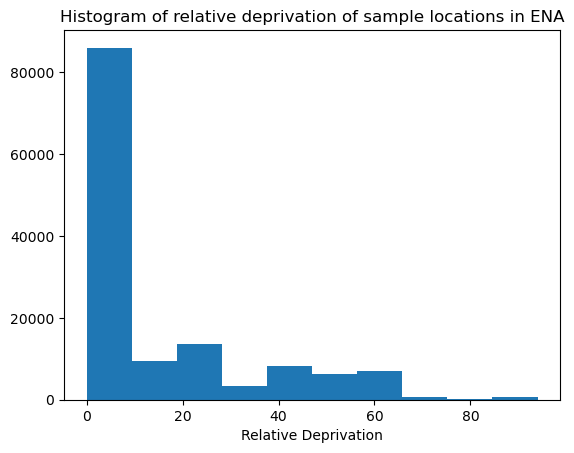

In [24]:
plt.hist(x = ena_annotations_env["Relative Deprivation"])
plt.xlabel('Relative Deprivation')
plt.title('Histogram of relative deprivation of sample locations in ENA')